In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#data = pd.read_csv('ACMTermPremium(3).csv', parse_dates=['date'], index_col='date')
data = pd.read_excel('./ACMTermPremium.xls',sheet_name='ACM Daily')


# import data and clean

In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *
from datetime import datetime
ARIMAtrainsize = 0.98
SVRtrainsize = 0.9
LSTMtrainsize = 0.95
# datatime
def load_ACM(data): # Load GSW dataset.               
    for i in range(len(data['DATE'])):
        data.iloc[i, 0] = datetime.strptime(data.iloc[i, 0], '%d-%b-%Y') # parse strings in 'Date' column and turn it into datetime object

    data = data.set_index(data['DATE']) # set date as index 
    data.index = pd.to_datetime(data.index)
    data = data.resample('BM').last() # use the last data in each month as proxy for the month's data 
    data.index = pd.to_datetime(data.index)
    data.index = data.index + DateOffset() # move index forward by one day so that it becomes the first business day of the month
    plot_dates = pd.to_datetime(data['DATE']) # create the 'plot_data' output in type of datetime for matpoltlib plotting
    df = data.drop('DATE',axis=1)

    return df, plot_dates 

In [3]:
rawTP, plot_dates = load_ACM(data)

In [4]:
TP = pd.DataFrame(rawTP).iloc[:,10:20]
TP

,ACMTP01,ACMTP02,ACMTP03,ACMTP04,ACMTP05,ACMTP06,ACMTP07,ACMTP08,ACMTP09,ACMTP10
DATE,,,,,,,,,,
1961-07-01,-0.059029,0.013501,0.087279,0.137291,0.167511,0.185559,0.197023,0.205105,0.211328,0.216199
1961-08-01,0.032467,0.150773,0.254280,0.325050,0.370683,0.400696,0.421721,0.437583,0.450203,0.460372
1961-09-01,-0.029397,0.071517,0.167147,0.232845,0.274275,0.300570,0.318358,0.331500,0.341922,0.350384
1961-09-30,0.004456,0.078921,0.140956,0.180722,0.204958,0.220521,0.231759,0.240916,0.248887,0.255805
1961-11-01,-0.019939,0.060036,0.145054,0.208603,0.252739,0.284002,0.307497,0.326281,0.341895,0.354947
...,...,...,...,...,...,...,...,...,...,...
2022-12-31,-0.194036,-0.369355,-0.495528,-0.567258,-0.598010,-0.601927,-0.589400,-0.567358,-0.540352,-0.511421
2023-02-01,-0.276391,-0.526226,-0.699128,-0.794210,-0.833592,-0.838018,-0.821962,-0.794672,-0.761942,-0.727449
2023-03-01,0.068336,-0.140318,-0.348161,-0.480695,-0.543362,-0.557753,-0.542477,-0.510371,-0.469694,-0.425672


In [5]:
# check nan

TP.fillna(method='ffill', inplace=True)
TP.fillna(method='bfill', inplace=True)
has_nans = TP.isnull().any().any()
has_infs = TP.applymap(np.isinf).any().any()

print(f"TP contains NaNs: {has_nans}")
print(f"TP contains Infs: {has_infs}")

TP contains NaNs: False
TP contains Infs: False


In [6]:
#TP['ACMTP02'].isnull().any().any()

In [7]:
'''
def is_stationary(data, significance_level=0.05):
    adf_result = adfuller(data)
    p_value = adf_result[1]
    return p_value < significance_level

# 对每个列进行ADF检验和差分处理，需要run十遍,发现都做一阶就好了，只要设置ARIMA d参数为1
for column in TP.columns:
    TP[column].fillna(method='ffill', inplace=True)
    TP[column].fillna(method='bfill', inplace=True)
    print(f"Processing column: {column}")
    
    # 检查数据是否平稳
    if not is_stationary(TP[column]):
        print(f"Data for {column} is not stationary. Applying differencing.")
        
        # 对数据进行差分处理
        TP[column] = TP[column].diff().dropna()

        # 再次检查数据是否平稳
        if is_stationary(TP[column]):
            print(f"TP for {column} is now stationary after differencing.")
        else:
            print(f"TP for {column} is still not stationary after differencing. Further differencing may be required.")
    else:
        print(f"TP for {column} is already stationary.")'''

'\ndef is_stationary(data, significance_level=0.05):\n    adf_result = adfuller(data)\n    p_value = adf_result[1]\n    return p_value < significance_level\n\n# 对每个列进行ADF检验和差分处理，需要run十遍,发现都做一阶就好了，只要设置ARIMA d参数为1\nfor column in TP.columns:\n    TP[column].fillna(method=\'ffill\', inplace=True)\n    TP[column].fillna(method=\'bfill\', inplace=True)\n    print(f"Processing column: {column}")\n    \n    # 检查数据是否平稳\n    if not is_stationary(TP[column]):\n        print(f"Data for {column} is not stationary. Applying differencing.")\n        \n        # 对数据进行差分处理\n        TP[column] = TP[column].diff().dropna()\n\n        # 再次检查数据是否平稳\n        if is_stationary(TP[column]):\n            print(f"TP for {column} is now stationary after differencing.")\n        else:\n            print(f"TP for {column} is still not stationary after differencing. Further differencing may be required.")\n    else:\n        print(f"TP for {column} is already stationary.")'

In [8]:
#跑了这个cell下面的就跑不出来了，这个的参数是2，0，1，AIC-8000左右
'''p_range = range(0, 3)  # AR阶数
d_range = range(0, 2)  # 差分阶数
q_range = range(0, 3)  # MA阶数

# 初始化最佳参数和最佳AIC值
# 这里如果循环跑每个的话会出现 too many indexes,所以直接用一年期限的ACMTP01的参数
best_params = None
best_aic = np.inf
data = data.loc[:'2000-01-01','ACMTP01']
# 遍历参数范围
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # 构建并拟合ARIMA模型
                model = ARIMA(data, order=(p, d, q))
                model_fit = model.fit()

                # 计算AIC
                aic = model_fit.aic

                # 更新最佳参数和最佳AIC值
                if aic < best_aic:
                    best_params = (p, d, q)
                    best_aic = aic
            except:
                # 如果模型无法拟合，跳过当前参数组合
                continue

print(f"Best ARIMA parameters: {best_params}, AIC: {best_aic}")'''

'p_range = range(0, 3)  # AR阶数\nd_range = range(0, 2)  # 差分阶数\nq_range = range(0, 3)  # MA阶数\n\n# 初始化最佳参数和最佳AIC值\n# 这里如果循环跑每个的话会出现 too many indexes,所以直接用一年期限的ACMTP01的参数\nbest_params = None\nbest_aic = np.inf\ndata = data.loc[:\'2000-01-01\',\'ACMTP01\']\n# 遍历参数范围\nfor p in p_range:\n    for d in d_range:\n        for q in q_range:\n            try:\n                # 构建并拟合ARIMA模型\n                model = ARIMA(data, order=(p, d, q))\n                model_fit = model.fit()\n\n                # 计算AIC\n                aic = model_fit.aic\n\n                # 更新最佳参数和最佳AIC值\n                if aic < best_aic:\n                    best_params = (p, d, q)\n                    best_aic = aic\n            except:\n                # 如果模型无法拟合，跳过当前参数组合\n                continue\n\nprint(f"Best ARIMA parameters: {best_params}, AIC: {best_aic}")'

In [9]:
# 划分训练集和测试集

train_size = int(len(TP) * ARIMAtrainsize)
calendar =TP.index[train_size]
TPforecast = TP.loc[calendar:].copy()
TPTest = TP.loc[calendar:].copy()
st = len(TPTest.index)
for column in TP.columns:
    #c = TP.columns[i]
    train_data = TP.loc[:calendar,column]  # 保留最后st个月数据用于测试
    test_data = TP.loc[calendar:,column]

    # 构建并拟合ARIMA模型
    model = ARIMA(train_data, order=(2, 0, 1))
    model_fit = model.fit()

    # 进行预测
    forecast = model_fit.forecast(steps=st)  # 预测未来st个月的期限溢价
    forecast.index = TPforecast.index
    TPforecast.loc[:,column] = forecast
    
    #print(column)
    #print(type(forecast))
    #print(forecast)
TPforecast

,ACMTP01,ACMTP02,ACMTP03,ACMTP04,ACMTP05,ACMTP06,ACMTP07,ACMTP08,ACMTP09,ACMTP10
DATE,,,,,,,,,,
2022-03-01,-0.147022,-0.223076,-0.292369,-0.383083,-0.458834,-0.520278,-0.569456,-0.607200,-0.643555,-0.676409
2022-04-01,-0.162937,-0.228121,-0.270720,-0.359573,-0.433116,-0.493097,-0.540720,-0.580339,-0.616174,-0.648567
2022-04-30,-0.174632,-0.230605,-0.249605,-0.336894,-0.408184,-0.465433,-0.509613,-0.558071,-0.593674,-0.625806
2022-06-01,-0.183065,-0.231123,-0.228973,-0.314403,-0.383504,-0.439052,-0.481122,-0.537408,-0.572739,-0.604587
2022-07-01,-0.188978,-0.230134,-0.208841,-0.292590,-0.359469,-0.412549,-0.451699,-0.517413,-0.552420,-0.583953
2022-07-30,-0.192944,-0.227994,-0.189177,-0.271051,-0.335760,-0.387012,-0.423839,-0.497790,-0.532442,-0.563644
2022-09-01,-0.195407,-0.224978,-0.169985,-0.250088,-0.312608,-0.361569,-0.395758,-0.478446,-0.512726,-0.543588
2022-10-01,-0.196712,-0.221299,-0.151242,-0.229448,-0.289819,-0.336891,-0.368705,-0.459348,-0.493248,-0.523764
2022-11-01,-0.197123,-0.217120,-0.132947,-0.209313,-0.267527,-0.312435,-0.341779,-0.440486,-0.473999,-0.504164


In [10]:
#print(test_data)
#print(TPforecast['ACMTP01'])
#print(TPTest)

In [11]:
# 计算预测准确性
from sklearn.metrics import mean_squared_error

for column in TPforecast.columns:
    msearima = mean_squared_error(TPTest[column], TPforecast[column])
    print('预测均方误差：', msearima)



预测均方误差： 0.032384795914685516
预测均方误差： 0.06211582582628691
预测均方误差： 0.14832893654379067
预测均方误差： 0.15255002510657528
预测均方误差： 0.1438992093830256
预测均方误差： 0.12875630875270866
预测均方误差： 0.11498728789567939
预测均方误差： 0.06966150547896197
预测均方误差： 0.059008314132342726
预测均方误差： 0.05290064179871083


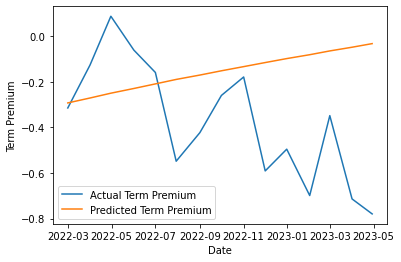

In [12]:
# 可视化预测结果
import matplotlib.pyplot as plt
plt.plot(TPTest.iloc[:,2], label='Actual Term Premium')
plt.plot(TPforecast.iloc[:,2], label='Predicted Term Premium')
plt.xlabel('Date')
plt.ylabel('Term Premium')
plt.legend()
plt.show()

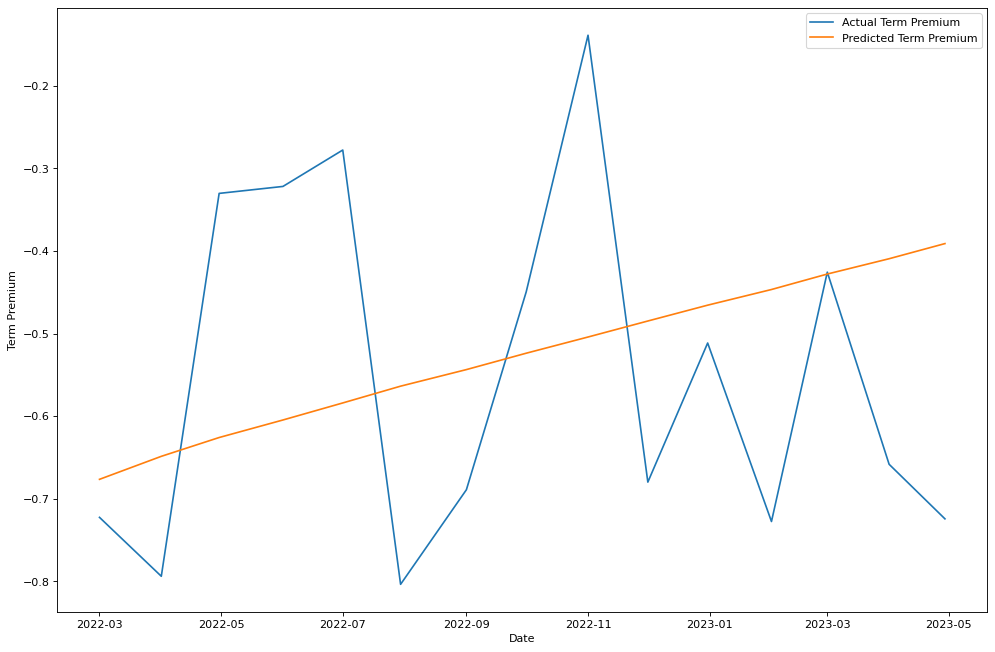

In [13]:
plt.figure(figsize=(15, 10), facecolor=(1, 1, 1), dpi=80)
plt.plot(TPTest.iloc[:,9], label='Actual Term Premium')
plt.plot(TPforecast.iloc[:,9], label='Predicted Term Premium')
plt.xlabel('Date')
plt.ylabel('Term Premium')
plt.legend()
#plt.savefig("./ARIMA%f.png"%ARIMAtrainsize)

# SVR

In [14]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


def forecast_SVR(colname):
    # 特征和目标变量
    X = np.array(TP.index).reshape(-1, 1)
    y = TP[colname]
    train_size = int(len(X) * SVRtrainsize)
    # 划分训练集和测试集
    
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    testdate = TP.index[train_size:]
    
    # 数据标准化
    scaler_X = StandardScaler().fit(X_train)
    scaler_y = StandardScaler().fit(y_train.values.reshape(-1, 1))
    X_train_scaled = scaler_X.transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).ravel()

    # 构建并拟合SVR模型
    model = SVR(kernel='rbf', C=1, epsilon=0.1)
    model.fit(X_train_scaled, y_train_scaled)

    # 预测
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    
    #pred_df = pd.DataFrame(y_pred, index=test_dates, columns=['Prediction'])

    # 计算预测准确性
    mse = mean_squared_error(y_test, y_pred)
    
    return X_test,y_test,y_pred,mse,testdate




In [15]:
X_test,y_test,y_pred,mse,testdate = forecast_SVR('ACMTP01')
pred_df = pd.DataFrame(columns=['ACMTP01'], index=testdate)
#X_test,y_test,y_pred,mse = forecast_SVR(i)
test_df = pd.DataFrame(columns=['ACMTP01'], index=testdate)


In [16]:
X_test,y_test,y_pred,mse,testdate = forecast_SVR('ACMTP01')
pred_df = pd.DataFrame(columns=['ACMTP01'], index=testdate)
#X_test,y_test,y_pred,mse = forecast_SVR(i)
test_df = pd.DataFrame(columns=['ACMTP01'], index=testdate)
#X_test_df = pd.DataFrame(X_test)
#pred_df = pd.DataFrame()
for i in TP.columns:
    X_test,y_test,y_pred,mse,testdate = forecast_SVR(i)
    pred_df[i]= y_pred
    #pred_df.index=testdate
    test_df[i] = y_test
    print(mse)
    #X_test_df[i] = X_test
    


0.07764585974703991
0.09151898524401442
0.08166490767351897
0.08391144051205558
0.10140130237830683
0.11842811178950934
0.13456874731496685
0.15610989354630314
0.18238789524535742
0.22269831666338774


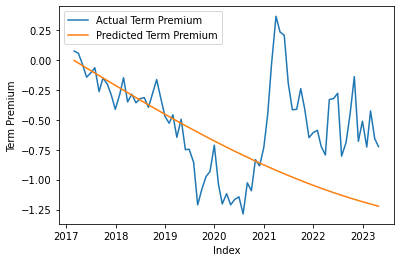

In [17]:
# 可视化预测结果
plt.plot(X_test, test_df.iloc[:,9], label='Actual Term Premium')
plt.plot(X_test, pred_df.iloc[:,9], label='Predicted Term Premium')
plt.xlabel('Index')
plt.ylabel('Term Premium')
plt.legend()
plt.show()

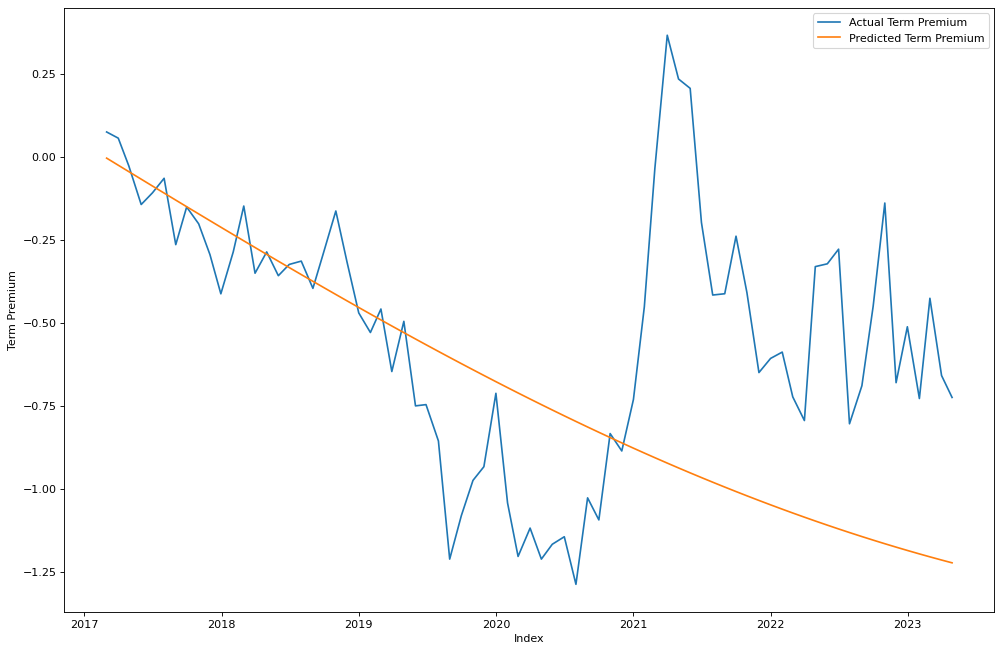

In [18]:
plt.figure(figsize=(15, 10), facecolor=(1, 1, 1), dpi=80)
plt.plot(X_test, test_df.iloc[:,9], label='Actual Term Premium')
plt.plot(X_test, pred_df.iloc[:,9], label='Predicted Term Premium')
plt.xlabel('Index')
plt.ylabel('Term Premium')
plt.legend()
#plt.savefig("./SVR10_result%f.png"%SVRtrainsize)

# Longshort Term Memory

In [19]:
singleTP = TP['ACMTP10'].copy()
singleTP = pd.DataFrame(singleTP)
singleTP

,ACMTP10
DATE,
1961-07-01,0.216199
1961-08-01,0.460372
1961-09-01,0.350384
1961-09-30,0.255805
1961-11-01,0.354947
...,...
2022-12-31,-0.511421
2023-02-01,-0.727449
2023-03-01,-0.425672


Epoch 1/20
702/702 [==============================] - 2s 786us/step - loss: 0.0122
Epoch 2/20
702/702 [==============================] - 1s 767us/step - loss: 0.0022
Epoch 3/20
702/702 [==============================] - 1s 801us/step - loss: 0.0021
Epoch 4/20
702/702 [==============================] - 1s 814us/step - loss: 0.0021
Epoch 5/20
702/702 [==============================] - 1s 761us/step - loss: 0.0021
Epoch 6/20
702/702 [==============================] - 1s 776us/step - loss: 0.0019
Epoch 7/20
702/702 [==============================] - 1s 758us/step - loss: 0.0019
Epoch 8/20
702/702 [==============================] - 1s 759us/step - loss: 0.0020
Epoch 9/20
702/702 [==============================] - 1s 763us/step - loss: 0.0019
Epoch 10/20
702/702 [==============================] - 1s 763us/step - loss: 0.0019
Epoch 11/20
702/702 [==============================] - 1s 787us/step - loss: 0.0017
Epoch 12/20
702/702 [==============================] - 1s 770us/step - loss: 0.0018
E

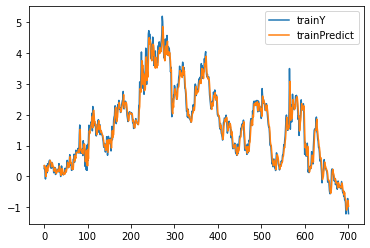

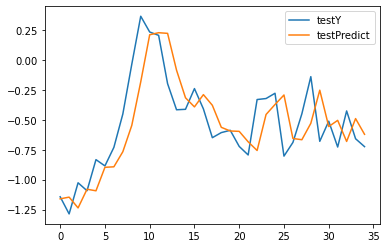

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

tf.random.set_seed(333)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(singleTP)

# 划分训练集和测试集
train_size = int(len(scaled_data) * LSTMtrainsize)
train, test = scaled_data[:train_size, :], scaled_data[train_size:, :]

# 构建数据集
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
        #y.append(dataset[i + look_back, 0])  # 只选择第一个特征
    return np.array(X), np.array(y)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 为 LSTM 模型准备输入数据
#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[2]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[2]))
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1] * trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1] * testX.shape[2]))

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, input_shape=(1, trainX.shape[2]))) # 50 个神经元
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 训练模型
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)

# 预测
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 反归一化预测结果
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#trainScore = mean_squared_error(trainY.reshape(-1, 3), trainPredict)
#testScore = mean_squared_error(testY.reshape(-1, 3), testPredict)

#trainScore = mean_squared_error(trainY, trainPredict[:, 0])  # 只选择第一个预测输出
#testScore = mean_squared_error(testY, testPredict[:, 0])  # 只选择第一个预测输出

trainScore = mean_squared_error(trainY, trainPredict, multioutput='raw_values')
print('Train Mean Squared Error:', trainScore)
testScore = mean_squared_error(testY, testPredict, multioutput='raw_values')
print('Test Mean Squared Error:', testScore)

# 绘制预测和实际值
plt.plot(trainY[:, 0], label='trainY')
plt.plot(trainPredict[:, 0], label='trainPredict')
plt.legend()
plt.show()

plt.plot(testY[:, 0], label='testY')
plt.plot(testPredict[:, 0], label='testPredict')
plt.legend()
plt.show()


In [21]:
singleTP

,ACMTP10
DATE,
1961-07-01,0.216199
1961-08-01,0.460372
1961-09-01,0.350384
1961-09-30,0.255805
1961-11-01,0.354947
...,...
2022-12-31,-0.511421
2023-02-01,-0.727449
2023-03-01,-0.425672


In [22]:
c = np.array([trainX[-1,:]])
prediction = []

for i in range(testY.size):
    print(i,end='\r')
    prediction += [model.predict(c)[0,0]]
    c = np.roll(c,-1)
    c[0,0,-1] = prediction[-1]

prediction = scaler.inverse_transform(np.array(prediction).reshape(-1,1))

1/1 [==============================] - 0s 14ms/step


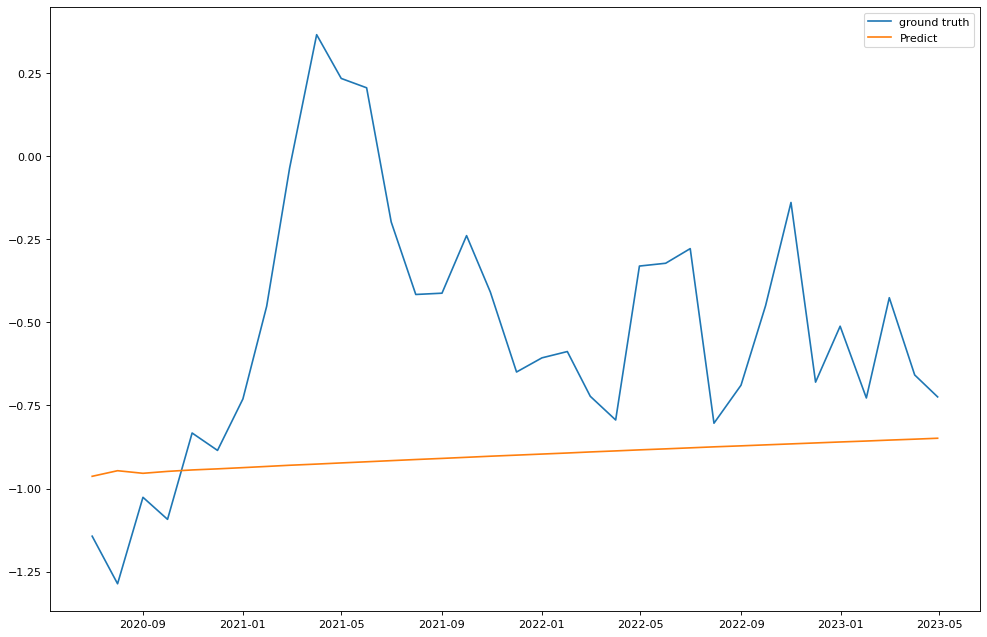

In [23]:
plt.figure(figsize=(15, 10), dpi=80)
plt.plot(singleTP[-testY.size:].index, testY[:,0], label='ground truth')
plt.plot(singleTP[-testY.size:].index, prediction[:, 0], label='Predict')
plt.legend()
plt.show()

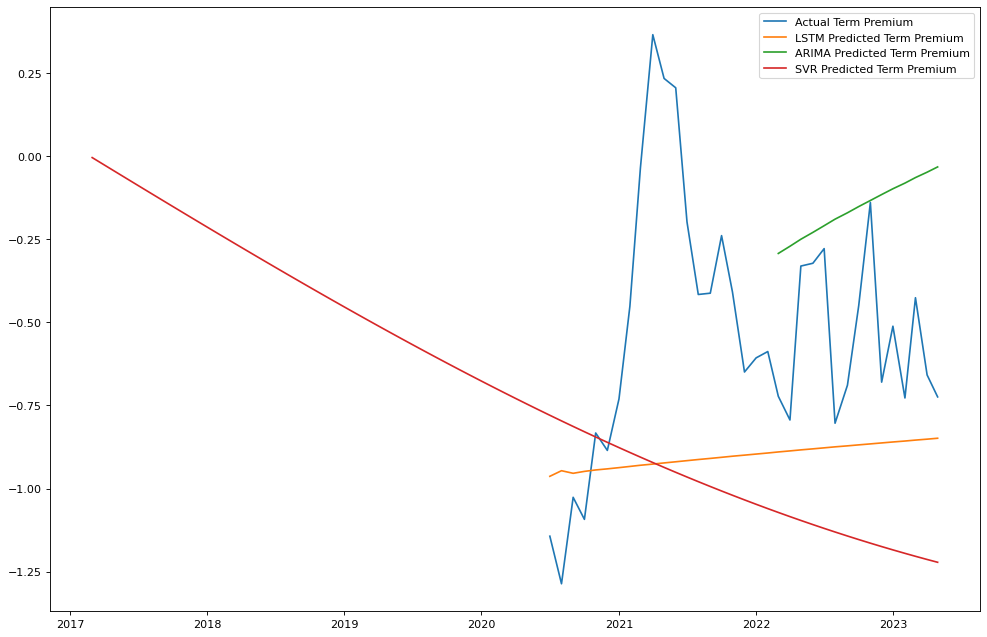

In [24]:
plt.figure(figsize=(15, 10), facecolor=(1, 1, 1), dpi=80)
plt.plot(singleTP[-testY.size:].index, testY[:,0], label='Actual Term Premium')
plt.plot(singleTP[-testY.size:].index, prediction[:, 0], label='LSTM Predicted Term Premium')
plt.plot(TPforecast.iloc[:,2], label='ARIMA Predicted Term Premium')
plt.plot(X_test, pred_df.iloc[:,9], label='SVR Predicted Term Premium')
plt.legend()
#plt.savefig("./models_result%f.png"%LSTMtrainsize)


In [25]:
print([ARIMAtrainsize,SVRtrainsize,LSTMtrainsize])
print([msearima,mse,testScore[0]])

[0.98, 0.9, 0.95]
[0.05290064179871083, 0.22269831666338774, 0.06476995977927065]
